In [38]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from vosk import Model
from Signal_Analysis.features.signal import get_HNR
from scipy import signal
from audiostretchy.stretch import stretch_audio


# tools work in progress
import tools

reload(tools)

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")

In [2]:
import os
from librosa import load

examples_dir = "example_speech_mp3/svenska"
filenames = os.listdir(examples_dir)
print(filenames)
audios = []
for f in filenames:
    y, Fs = load(os.path.join(examples_dir, f), sr=None)
    audios.append(y)

wavfile.write("wav_examples/svenska_combo.wav", Fs, tools.stitch_frames(audios))


['common_voice_sv-SE_38528961.mp3', 'common_voice_sv-SE_38528962.mp3', 'common_voice_sv-SE_38528964.mp3', 'common_voice_sv-SE_38528967.mp3', 'common_voice_sv-SE_38528968.mp3', 'common_voice_sv-SE_38543999.mp3', 'common_voice_sv-SE_38544000.mp3', 'common_voice_sv-SE_38544001.mp3', 'common_voice_sv-SE_38544002.mp3', 'common_voice_sv-SE_38544004.mp3', 'common_voice_sv-SE_38544013.mp3', 'common_voice_sv-SE_38544014.mp3', 'common_voice_sv-SE_38544015.mp3', 'common_voice_sv-SE_38544016.mp3', 'common_voice_sv-SE_38544017.mp3', 'common_voice_sv-SE_38568655.mp3', 'common_voice_sv-SE_38568656.mp3', 'common_voice_sv-SE_38568657.mp3', 'common_voice_sv-SE_38568658.mp3', 'common_voice_sv-SE_38568659.mp3', 'common_voice_sv-SE_38568660.mp3', 'common_voice_sv-SE_38568661.mp3', 'common_voice_sv-SE_38568662.mp3', 'common_voice_sv-SE_38568663.mp3', 'common_voice_sv-SE_38568664.mp3', 'common_voice_sv-SE_38568670.mp3', 'common_voice_sv-SE_38568671.mp3', 'common_voice_sv-SE_38568672.mp3', 'common_voice_sv-SE

## preprocess

In [3]:
audio_original_path = "wav_examples/svenska_combo.wav"
_ = tools.preprocess(audio_original_path)


preprocessing svenska_combo


## Speech recognition

In [4]:
audio_path = "audio_preproc/svenska_combo_pp.wav"
Fs, audio = wavfile.read(audio_path)
model_path = "models/vosk-model-small-sv-rhasspy-0.15/"
if "model" not in locals():
    model = Model(model_path)

0 åter ---------------- from 0.42 to 0.87 sec, confidence: 70.03%
1 förvillande --------- from 0.87 to 1.23 sec, confidence: 54.71%
2 vildanden ----------- from 1.23 to 1.53 sec, confidence: 45.29%
3 av ------------------ from 1.56 to 1.68 sec, confidence: 70.56%
4 borås --------------- from 1.68 to 2.19 sec, confidence: 100.00%
5 låg ----------------- from 2.19 to 2.40 sec, confidence: 58.75%
6 högst --------------- from 2.43 to 2.85 sec, confidence: 100.00%
7 på ------------------ from 2.85 to 2.97 sec, confidence: 71.55%
8 agenda -------------- from 2.97 to 3.60 sec, confidence: 63.37%
9 utredaren ----------- from 4.38 to 5.07 sec, confidence: 82.97%
10 ska ----------------- from 5.07 to 5.22 sec, confidence: 100.00%
11 vidare -------------- from 5.22 to 5.61 sec, confidence: 100.00%
12 inhämta ------------- from 5.61 to 6.15 sec, confidence: 100.00%
13 synpunkter ---------- from 6.15 to 6.81 sec, confidence: 100.00%
14 från ---------------- from 6.84 to 7.02 sec, confidence: 100.00

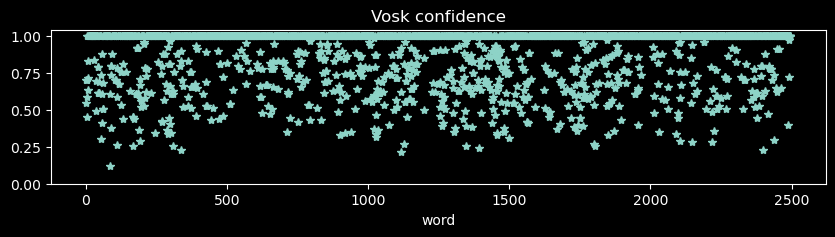

In [22]:
words = tools.rec_vosk(audio_path, model, print_summary=True)

text = " ".join([w["word"] for w in words])


print(text)
plt.figure(figsize=(10, 2))
plt.plot([w["conf"] for w in words], "*")
plt.title("Vosk confidence")
plt.xlabel("word")
plt.ylim(bottom=0)
plt.show()

In [6]:
# get all vowels
for w in words:
    w["vowels"] = tools.checkVowels(w["word"], tools.VOWELS_SV)

for w in words:
    print(w["word"], w["vowels"], str(w["conf"] * 100) + "%")

åter ['å', 'e'] 69.3943%
förvillande ['ö', 'i', 'a', 'e'] 54.1462%
vildanden ['i', 'a', 'e'] 45.8538%
av ['a'] 70.2828%
borås ['o', 'å'] 100.0%
låg ['å'] 58.1084%
högst ['ö'] 100.0%
på ['å'] 71.91149999999999%
agenda ['a', 'e', 'a'] 71.91149999999999%
utredaren ['u', 'e', 'a', 'e'] 82.3896%
ska ['a'] 100.0%
vidare ['i', 'a', 'e'] 100.0%
inhämta ['i', 'ä', 'a'] 100.0%
synpunkter ['y', 'u', 'e'] 100.0%
från ['å'] 100.0%
berörda ['e', 'ö', 'a'] 100.0%
myndigheter ['y', 'i', 'e', 'e'] 100.0%
organisationer ['o', 'a', 'i', 'a', 'i', 'o', 'e'] 100.0%
och ['o'] 100.0%
näringslivsdirektörens ['ä', 'i', 'i', 'i', 'e', 'ö', 'e'] 100.0%
jag ['a'] 100.0%
har ['a'] 100.0%
inte ['i', 'e'] 100.0%
läst ['ä'] 100.0%
något ['å', 'o'] 100.0%
av ['a'] 100.0%
honom ['o', 'o'] 100.0%
och ['o'] 100.0%
känner ['ä', 'e'] 84.1452%
honom ['o', 'o'] 100.0%
således ['å', 'e', 'e'] 100.0%
inte ['i', 'e'] 100.0%
vi ['i'] 100.0%
ska ['a'] 100.0%
förklara ['ö', 'a', 'a'] 100.0%
de ['e'] 49.923%
på ['å'] 100.0%
lekman 

## test 1 word

In [15]:
def HNR_short(frames, Fs, n_peaks=-1):
    """get frame index for peaks and hnr per frame"""
    hnr_frames = np.array([get_HNR(f, Fs) for f in frames])
    peaks, peaks_prop = signal.find_peaks(hnr_frames, height = 0.1*max(hnr_frames))
    peaks = peaks[(-peaks_prop['peak_heights']).argsort()[:n_peaks]]  # läskig one-liner
    return peaks, hnr_frames

borås
-----
frame length    : 640 samples
frame length    : 0.02 seconds
between frames  : 0.02 seconds
number of frames: 27


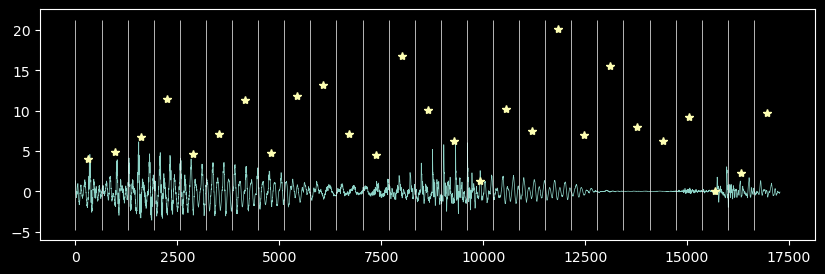

In [17]:
fl = int(0.02 * Fs)
k = 4
print(words[k]["word"])
print("-" * len(words[k]["word"]))
segments, vowels_per_segment = tools.segment_by_words(words, audio, Fs, tools.VOWELS_SV)
x = segments[k] / segments[k].std()
vowels = vowels_per_segment[k]


frames, f_start = tools.split_frames(x, fl, Fs, overlap=0, print_info=True)

peak_frames, hnr_frames = HNR_short(frames, Fs, len(vowels))

plt.figure(figsize=(10, 3))
plt.plot(x)
plt.plot(f_start + int(fl / 2), hnr_frames, "*")
plt.vlines(f_start, *plt.ylim())

plt.show()

In [483]:
grouped = {v: [] for v in tools.VOWELS_SV}
print(vowels)
print(len(frames))
print(len(peak_frames))

if len(peak_frames) == len(vowels):
    for i, v in enumerate(vowels):
        grouped[v].append(frames[peak_frames[i]])

['i', 'a', 'e']
20
3


In [25]:
def checkIfWhite(signal, wNoiseRatio=0.8):
    sum0, sum1 = 0, 0
    for i in range(1, len(signal)):
        sum0 += abs(signal[i])
        sum1 += abs(signal[i]-signal[i-1])
    return (sum1/sum0 > wNoiseRatio)

## all words

In [39]:
grouped = {v: [] for v in tools.VOWELS_SV}
segments, vowels_per_segment = tools.segment_by_words(words, audio, Fs, tools.VOWELS_SV)
for w, segment, vowels in zip(words, segments, vowels_per_segment):
    if w["conf"] >= 1:
        #print(w["word"], w["conf"])
        frames, f_start = tools.split_frames(segment, fl, Fs, overlap=0)
        peak_frames, hnr_frames = HNR_short(frames, Fs, len(vowels))
        if len(peak_frames) == len(vowels):
            for i, v in enumerate(vowels):
                if(not checkIfWhite(frames[peak_frames[i]])):
                    grouped[v].append(frames[peak_frames[i]])

audio_out = {}
for v in grouped.keys():
    audio_out[v] = tools.stitch_frames(grouped[v], fade_pow=0.5)
    path = f"output/concatenated/concatenated_{v}.wav"
    wavfile.write(path, Fs, audio_out[v])
    stretch_audio(path, path, 16)


c:\Users\tobia\anaconda3\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: divide by zero encountered in divide
  r_x = r_a / r_w
c:\Users\tobia\anaconda3\Lib\site-packages\Signal_Analysis\features\signal.py:585: RuntimeWarning: invalid value encountered in divide
  r_x = r_a / r_w
c:\Users\tobia\anaconda3\Lib\site-packages\peakutils\peak.py:43: RuntimeWarning: invalid value encountered in scalar add
  thres = thres * (np.max(y) - np.min(y)) + np.min(y)


In [30]:
vowels_in_text = {v: 0 for v in tools.VOWELS_SV}
for c in tools.checkVowels(text, tools.VOWELS_SV):
    vowels_in_text[c] += 1

print("found vowels:")
for v in grouped.keys():
    print(
        "    ",
        v,
        len(grouped[v]),
        str(round(100 * len(grouped[v]) / vowels_in_text[v], 3)) + "%",
    )


found vowels:
     ä 128 49.612%
     a 543 49.589%
     ö 99 54.098%
     y 23 35.938%
     å 115 46.939%
     o 231 47.531%
     u 111 47.845%
     i 297 52.381%
     e 573 49.312%


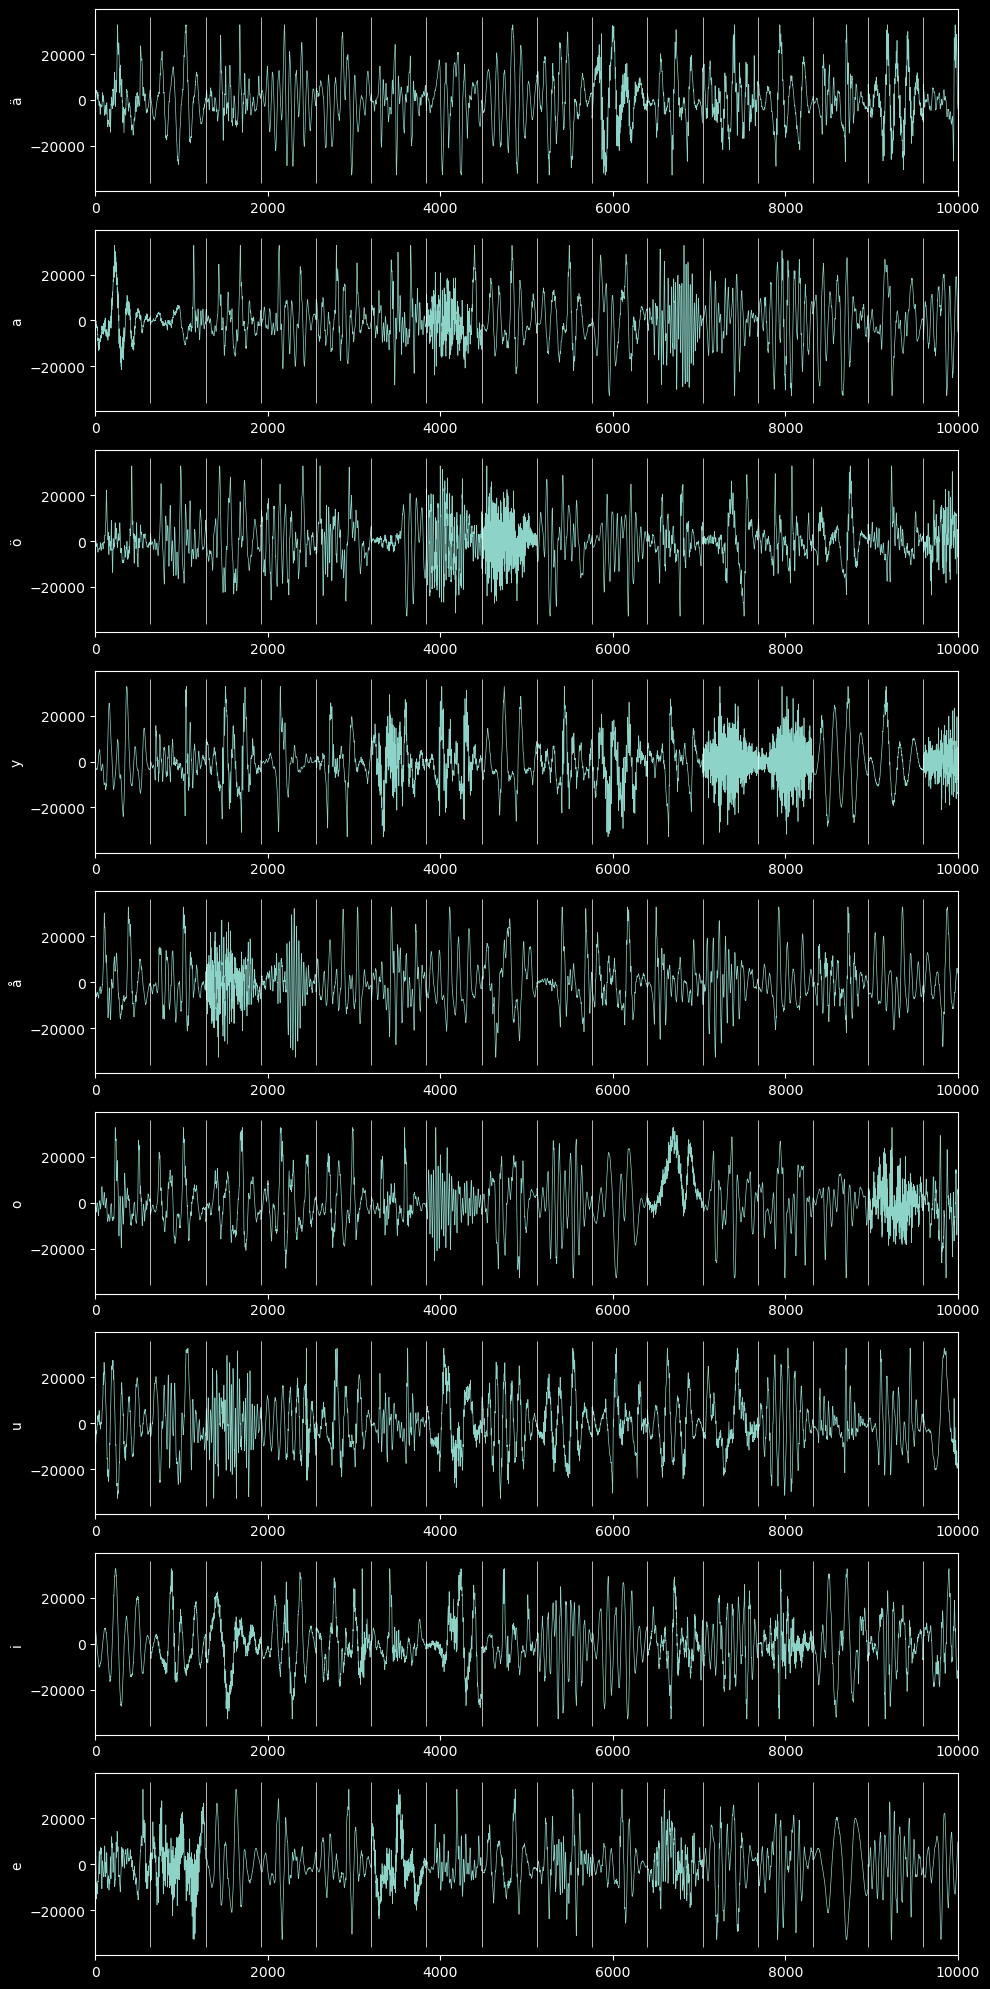

In [33]:
plt.figure(figsize=((10, 20)))
for i, v in enumerate(audio_out.keys()):
    plt.subplot(len(tools.VOWELS_SV), 1, i + 1)
    plt.plot(audio_out[v])
    plt.xlim(0, 10000)
    plt.vlines(np.arange(0, len(audio_out[v]), fl), *plt.ylim())
    plt.ylabel(v)

plt.tight_layout()
